In [1]:
import proplot
import xarray as xr

import plotting

In [2]:
plotting.configure_style()

In [3]:
def open_data(variable, validation_year):
    bias = xr.open_dataset("annual_mean_bias.nc")[[VARIABLE]].sel(validation_year=validation_year)
    metrics = xr.open_dataset("annual_mean_metrics.nc")[[VARIABLE]].sel(validation_year=validation_year)
    stack_dims = ("configuration", "time")
    return bias.stack(sample=stack_dims), metrics.stack(sample=stack_dims)

In [4]:
VALIDATION_YEAR = "Year two"
VARIABLE = "surface_temperature"
PALETTE = [
    "#E69F00",
    "#009E73",
    "#56B4E9",
]

bias, metrics = open_data(VARIABLE, VALIDATION_YEAR)

In [5]:
ML_CORRECTED_SAMPLES = bias.configuration == "ML-corrected seed 2"
BASELINE_SAMPLES = bias.configuration == "Baseline"
NUDGED_SAMPLES = (bias.configuration == "Nudged") & (bias.time.dt.year == 2018)
SAMPLES = ML_CORRECTED_SAMPLES | BASELINE_SAMPLES | NUDGED_SAMPLES

In [6]:
ml_corrected_bias = bias.isel(sample=ML_CORRECTED_SAMPLES).mean("sample")
baseline_bias = bias.isel(sample=BASELINE_SAMPLES).mean("sample")
nudged_bias = bias.isel(sample=NUDGED_SAMPLES).mean("sample")

In [7]:
land_rmse = plotting.to_plottable_dataframe(metrics, VARIABLE, "land", "rmse", SAMPLES)
land_bias = plotting.to_plottable_dataframe(metrics, VARIABLE, "land", "mean", SAMPLES)

/home/spencerc/miniconda3/envs/fv3net-makefile/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


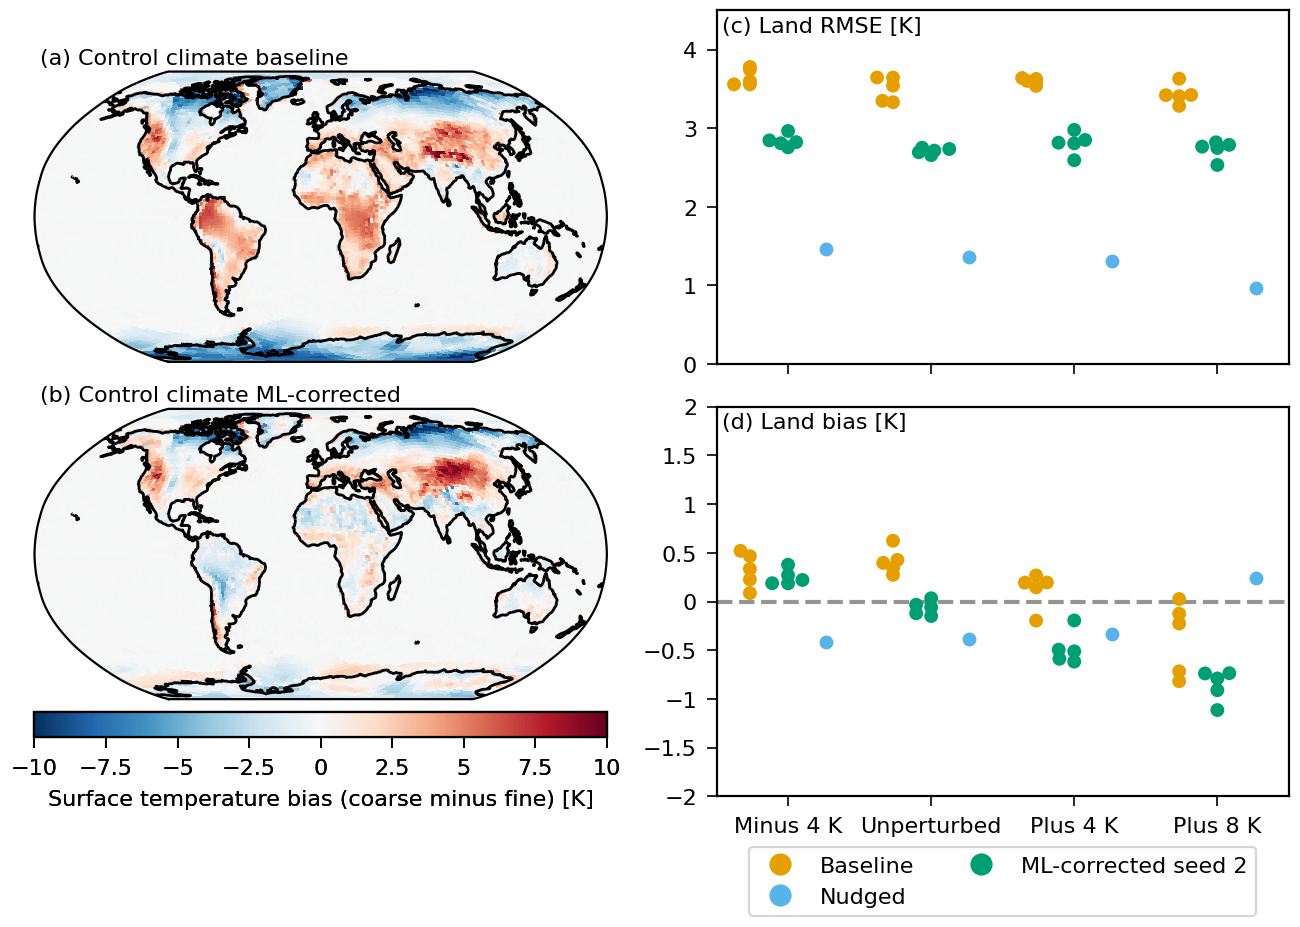

In [9]:
array = [
    [0, 2],
    [1, 2],
    [1, 2],
    [1, 2],
    [1, 2],
    [1, 2],
    [3, 4],
    [3, 4],
    [3, 4],
    [3, 4],
    [3, 4],
    [0, 4]
]
fig, axes = proplot.subplots(
    array,
    figwidth=6.5,
    refnum=2,
    refaspect=1/0.618,
    proj=["robin", None, "robin"],
    sharey="labels"
)

ax1, ax2, ax3, ax4 = axes

p = plotting.plot_map(ax1, baseline_bias.sel(climate="Unperturbed"), VARIABLE, -10, 10, discrete=False)
p = plotting.plot_map(ax3, ml_corrected_bias.sel(climate="Unperturbed"), VARIABLE, -10, 10, discrete=False)


plotting.swarmplot_by_category(
    ax2,
    land_rmse,
    VARIABLE,
    PALETTE,
    add_legend=False,
    dodge=True,
    x="climate"
)
ax2.set_ylim(0, 4.5)
ax2.set_ylabel("")

plotting.swarmplot_by_category(
    ax4,
    land_bias,
    VARIABLE,
    PALETTE,
    dodge=True,
    x="climate",
    add_legend=True,
    legend_kwargs={"loc": "bottom", "ncol": 2}
)
ax4.set_ylim(-2, 2)
ax4.set_ylabel("")
ax4.axhline(0.0, color="gray", ls="--")

for ax in axes:
    ax.set_xlabel("")    
    
ax1.annotate("(a) Control climate baseline", xy=(0, 1.1), xytext=(2, -2), va='top', xycoords='axes fraction', textcoords='offset points')
ax3.annotate("(b) Control climate ML-corrected", xy=(0, 1.1), xytext=(2, -2), va='top', xycoords='axes fraction', textcoords='offset points')
ax2.annotate("(c) Land RMSE [K]", xy=(0, 1), xytext=(2, -2), va='top', xycoords='axes fraction', textcoords='offset points')
ax4.annotate("(d) Land bias [K]", xy=(0, 1), xytext=(2, -2), va='top', xycoords='axes fraction', textcoords='offset points')

ax3.colorbar(p, loc="bottom", width=0.125, label="Surface temperature bias (coarse minus fine) [K]")

fig.savefig("figure-10.png", dpi=200)
fig.savefig("figure-10.pdf")